In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

import datetime as dt

import stac

import time

## Obter imagens da área de interesse via STAC (BrazilDataCube)

In [5]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto -46.872, -17.150 ("centroide" de paracatu).

items_sentinel = bdc_stac_service.search({'collections':['S2_MSI_L2_SR_LASRC-1'],
                                          "intersects": {"type": "Point",
                                                         "coordinates": [-46.832, -17.220]},
                                          'limit': 1000})

items_landsat = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                         "intersects": {"type": "Point",
                                                        "coordinates": [-46.832, -17.220]},
                                         'limit': 1000})

# Mostrar quantas imagens foram recuperadas
print('Sentinel: ', len(items_sentinel.features))
print('Landsat: ', len(items_landsat.features))

Sentinel:  965
Landsat:  98


date_sentinel = []
for i in items_sentinel.features:
    if '23KKA' in i['id']:
        date_sentinel.append(dt.datetime.strptime(i['properties']['datetime'],'%Y-%m-%dT%H:%M:%S'))
    
fig = plt.subplots(figsize=(15,5))
plt.hist(x = date_sentinel, bins=500);

In [6]:
links_landsat = {}

# Percorrer todos o itens obtidos da STAC
for i in items_landsat.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links_landsat[date] = {'ndvi':i['assets']['sr_ndvi']['href'], 'fmask':i['assets']['Fmask4']['href']}

In [ ]:
df_landsat = gpd.read_file('./DADOS/amostras_final_23n.geojson')
df_landsat.set_index('ponto_id', inplace=True)
df_landsat_mask = df_landsat.copy()

In [10]:
# Para evitar a execução total dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out_landsat = np.load('./DADOS/out_sample_landsat.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out_landsat = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links_landsat.items():
        # Abrir a imagem da URL
        with rasterio.open(v['ndvi']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample((zip(df_landsat.geometry.x, df_landsat.geometry.y)))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out_landsat[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_sample_landsat.npy', out_landsat)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [11]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out_landsat.items():
    df_landsat.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_landsat.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
# df_landsat.rename(columns={'id': 'date'}, inplace=True)
df_landsat = df_landsat.sort_index().T/10000

In [12]:
df_landsat 

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2016-08-15,0.2254,0.2025,0.2351,0.2608,0.2254,0.5866,0.6290,0.6446,0.6280,0.5866,...,0.2651,0.2520,0.2531,0.2560,0.2651,0.3778,0.3322,0.3369,0.3375,0.3778
2016-08-31,0.2218,0.1835,0.2204,0.2101,0.2218,0.2458,0.2836,0.2556,0.2467,0.2458,...,0.2917,0.2794,0.2775,0.2674,0.2917,0.3309,0.1645,0.2846,0.1376,0.3309
2016-09-16,0.2157,0.2030,0.2235,0.2480,0.2157,0.5013,0.4942,0.4079,0.4730,0.5013,...,0.3226,0.3022,0.3066,0.3123,0.3226,0.3288,0.2924,0.2756,0.2810,0.3288
2016-10-02,0.2335,0.2164,0.2208,0.2768,0.2335,0.5985,0.6799,0.5766,0.6257,0.5985,...,0.2804,0.2544,0.2447,0.2554,0.2804,0.3636,0.2779,0.2820,0.2789,0.3636
2016-10-18,0.2672,0.2706,0.2874,0.2987,0.2672,0.6679,0.7448,0.6173,0.6766,0.6679,...,0.2908,0.2522,0.2568,0.2558,0.2908,0.2571,0.2390,0.2398,0.2380,0.2571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.2904,0.2750,0.4612,0.4620,0.2904,0.6011,0.7653,0.6175,0.6497,0.6011,...,0.2570,0.2544,0.2508,0.2575,0.2570,0.9207,0.9232,0.8933,0.9139,0.9207
2020-09-11,0.2782,0.2694,0.3824,0.4204,0.2782,0.5505,0.6630,0.5700,0.6192,0.5505,...,0.3300,0.3246,0.3622,0.3565,0.3300,0.7878,0.6280,0.4908,0.6910,0.7878
2020-09-27,0.1681,0.1621,0.2322,0.2643,0.1681,0.5681,0.6855,0.6543,0.6809,0.5681,...,0.2677,0.2534,0.2681,0.2752,0.2677,0.2641,0.2629,0.2650,0.2641,0.2641
2020-10-13,0.2652,0.2618,0.2918,0.3313,0.2652,0.5478,0.5320,0.5097,0.4955,0.5478,...,0.3932,0.3666,0.3722,0.3817,0.3932,0.2508,0.2446,0.2427,0.2674,0.2508


In [13]:
try:
    mask_landsat = np.load('./DADOS/out_sample_mask_landsat.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    mask_landsat = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links_landsat.items():
        # Abrir a imagem da URL
        with rasterio.open(v['fmask']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample((zip(df_landsat_mask.geometry.x, df_landsat_mask.geometry.y)))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            mask_landsat[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_sample_mask_landsat.npy', mask_landsat)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [14]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in mask_landsat.items():
    df_landsat_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_landsat_mask.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_landsat_mask = df_landsat_mask.sort_index().T

In [15]:
df_filtrado_landsat = pd.DataFrame(((-df_landsat_mask.mask(df_landsat_mask != 0)+1)*df_landsat))
# df_interpolado_landsat = df_filtrado_landsat.interpolate(method='linear', axis=0)

In [16]:
df_filtrado_landsat

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2016-08-15,0.2254,0.2025,0.2351,0.2608,0.2254,0.5866,0.6290,0.6446,0.6280,0.5866,...,NaN,NaN,0.2531,NaN,NaN,0.3778,0.3322,0.3369,0.3375,0.3778
2016-08-31,0.2218,NaN,0.2204,0.2101,0.2218,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16,0.2157,0.2030,0.2235,NaN,0.2157,0.5013,NaN,0.4079,0.4730,0.5013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-02,0.2335,0.2164,0.2208,0.2768,0.2335,0.5985,0.6799,0.5766,0.6257,0.5985,...,0.2804,0.2544,0.2447,0.2554,0.2804,0.3636,0.2779,0.2820,0.2789,0.3636
2016-10-18,0.2672,0.2706,0.2874,0.2987,0.2672,0.6679,0.7448,0.6173,0.6766,0.6679,...,0.2908,0.2522,0.2568,0.2558,0.2908,0.2571,0.2390,0.2398,0.2380,0.2571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.2904,0.2750,0.4612,0.4620,0.2904,0.6011,0.7653,0.6175,0.6497,0.6011,...,0.2570,0.2544,0.2508,0.2575,0.2570,0.9207,0.9232,0.8933,0.9139,0.9207
2020-09-11,0.2782,0.2694,0.3824,0.4204,0.2782,0.5505,0.6630,0.5700,0.6192,0.5505,...,0.3300,0.3246,0.3622,0.3565,0.3300,0.7878,0.6280,0.4908,0.6910,0.7878
2020-09-27,0.1681,0.1621,0.2322,0.2643,0.1681,0.5681,0.6855,0.6543,0.6809,0.5681,...,0.2677,0.2534,0.2681,0.2752,0.2677,0.2641,0.2629,0.2650,0.2641,0.2641
2020-10-13,NaN,0.2618,0.2918,0.3313,NaN,NaN,NaN,NaN,0.4955,NaN,...,0.3932,0.3666,0.3722,0.3817,0.3932,0.2508,0.2446,0.2427,NaN,0.2508


## Criar um dicionário com as datas e links das imagens

In [17]:
links_23kka = {}
links_23kkb = {}
links_23kla = {}
links_23klb = {}

links = {}

# Percorrer todos o itens obtidos da STAC
for i in items_sentinel.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    if '23KKA' == i['properties']['bdc:tile']:
        links_23kka[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KKB' == i['properties']['bdc:tile']:
        links_23kkb[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KLA' == i['properties']['bdc:tile']:
        links_23kla[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KLB' == i['properties']['bdc:tile']:
        links_23klb[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
links['23KKA'] = links_23kka
links['23KKB'] = links_23kkb
links['23KLA'] = links_23kla
links['23KLB'] = links_23klb

## Abrir arquivo de pontos

In [18]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/amostras_final_23s.geojson')

df.set_index('ponto_id', inplace=True)

A função 'sample' da biblioteca rasterio infelizmente apresenta um pequeno bug. Apesar de haver uma avaliação interna em relação a interseção do ponto à imagem, quando essa condição não é favorecida é retornado um array vazio (invés de NaN) e um erro é apresentado sempre que tentamos manipulá-lo. Por causa disso, foi necessário separar os pontos por imagens e chamar a função apenas para os pontos que intesectam cada imagem. 

Um detalhe é que, dessa forma, os pontos que estão localizados na área de sobreposição entre duas ou mais cena são amostrados apenas para primeira.

In [20]:
df_23kka = df.loc[df.name=='23KKA']
df_23kkb = df.loc[df.name=='23KKB']
df_23kla = df.loc[df.name=='23KLA']
df_23klb = df.loc[df.name=='23KLB']

df_23kka_mask = df_23kka.copy()
df_23kkb_mask = df_23kkb.copy()
df_23kla_mask = df_23kla.copy()
df_23klb_mask = df_23klb.copy()

In [36]:
df_23kka

ponto_id,776,777,778,779,780,791,792,793,794,795,...,11848,11849,11850,11851,11853,11864,11865,11866,11867,11868
2017-01-05,0.8909,0.9208,0.8880,0.5781,0.8909,0.4330,0.5511,0.9000,0.8607,0.4330,...,0.8731,0.8263,0.8746,0.8731,0.8263,0.9033,0.9086,0.9195,0.9035,0.9033
2017-01-15,0.5480,0.2833,0.2870,0.6254,0.5480,0.4108,0.4823,0.4352,0.3768,0.4108,...,0.1880,0.2737,0.2221,0.2133,0.2737,0.8196,0.6228,0.4401,0.6488,0.8196
2017-01-25,0.8483,0.9157,0.9101,0.3437,0.8483,0.2849,0.2871,0.9059,0.9072,0.2849,...,0.9079,0.9180,0.9287,0.9311,0.9180,0.9008,0.8382,0.8762,0.8854,0.9008
2017-02-14,0.7530,0.8601,0.8154,0.4726,0.7530,0.3066,0.3818,0.7840,0.7706,0.3066,...,0.4195,0.6294,0.7402,0.6570,0.6294,0.9214,0.8907,0.8904,0.8894,0.9214
2017-02-24,0.4888,0.6239,0.5190,0.6428,0.4888,0.2470,0.2872,0.4919,0.2483,0.2470,...,0.4535,0.8549,0.8211,0.8456,0.8549,0.7209,0.7472,0.6983,0.7354,0.7209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11,0.4385,0.5146,0.3822,0.3840,0.4385,0.4664,0.4272,0.4067,0.4801,0.4664,...,0.3174,0.5420,0.3656,0.4946,0.5420,0.4605,0.4360,0.4316,0.4432,0.4605
2019-12-16,0.4705,0.7406,0.6844,0.3492,0.4705,0.5550,0.5594,0.1367,0.1649,0.5550,...,0.2884,0.9270,0.9325,0.9329,0.9270,0.3966,0.3841,0.3393,0.3419,0.3966
2019-12-21,0.2006,0.1656,0.1817,0.2129,0.2006,0.2280,0.1895,0.2169,0.2276,0.2280,...,0.2489,0.7375,0.7125,0.6419,0.7375,0.5245,0.5241,0.4816,0.4912,0.5245
2019-12-26,0.4683,0.5576,0.4765,0.4688,0.4683,0.4143,0.5160,0.1961,0.2638,0.4143,...,0.4550,0.8399,0.8871,0.8730,0.8399,0.4337,0.4899,0.5034,0.6162,0.4337


In [37]:
df_23kkb

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11623,11624,11625,11626,11627,11653,11654,11655,11656,11657
2017-01-05,0.6711,0.5937,0.6222,0.6487,0.6711,0.5712,0.7822,0.7286,0.7363,0.5712,...,0.8438,0.8634,0.7175,0.7467,0.8438,0.8748,0.8506,0.6224,0.8955,0.8748
2017-01-08,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01-15,0.4933,0.5015,0.5455,0.5138,0.4933,0.5026,0.5304,0.4468,0.5045,0.5026,...,0.2338,0.2180,0.1900,0.1904,0.2338,0.2266,0.3191,0.2267,0.3444,0.2266
2017-01-25,0.5644,0.6632,0.5464,0.6667,0.5644,0.7498,0.6492,0.5637,0.5621,0.7498,...,0.7511,0.8673,0.6749,0.7342,0.7511,0.8562,0.8601,0.3567,0.8856,0.8562
2017-01-28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2019-12-26,0.2387,0.2215,0.2523,0.2376,0.2387,0.2409,0.2318,0.2180,0.2264,0.2409,...,0.2683,0.3056,0.3945,0.2595,0.2683,0.8770,0.8785,0.8748,0.8746,0.8770
2019-12-29,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2019-12-31,0.8739,0.8869,0.9025,0.9089,0.8739,0.7232,0.7755,0.8640,0.8724,0.7232,...,0.8126,0.7492,0.6868,0.8262,0.8126,0.0369,0.0113,0.1127,0.0227,0.0369


In [38]:
df_23kla

ponto_id,586,587,588,589,590,611,612,613,614,615,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2017-01-05,0.3865,0.2627,0.2763,0.3723,0.3865,0.3316,0.2911,0.4451,0.5415,0.3316,...,0.8280,0.8059,0.8316,0.8297,0.8280,0.8454,0.8528,0.8445,0.8407,0.8454
2017-01-15,0.4612,0.5710,0.4172,0.2028,0.4612,0.7301,0.6013,0.6167,0.7384,0.7301,...,0.6915,0.7465,0.7811,0.7382,0.6915,0.6803,0.6828,0.6339,0.6974,0.6803
2017-01-25,0.6529,0.6195,0.4936,0.6287,0.6529,0.5673,0.6667,0.5436,0.7157,0.5673,...,0.8386,0.8791,0.8637,0.8390,0.8386,0.8930,0.8928,0.8894,0.8852,0.8930
2017-02-14,0.9184,0.9320,0.9066,0.9374,0.9184,0.8190,0.9203,0.7903,0.8829,0.8190,...,0.3509,0.1900,0.5554,0.7115,0.3509,0.5704,0.7438,0.4136,0.3241,0.5704
2017-02-24,0.8773,0.9024,0.8762,0.9002,0.8773,0.8465,0.8976,0.7953,0.8604,0.8465,...,0.6158,0.6040,0.5927,0.5771,0.6158,0.5453,0.5225,0.4819,0.5267,0.5453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11,0.9156,0.9342,0.9245,0.9262,0.9156,0.9251,0.9295,0.9338,0.9342,0.9251,...,0.4459,0.5033,0.2460,0.2056,0.4459,0.7519,0.8007,0.6449,0.9626,0.7519
2019-12-16,0.9074,0.9389,0.9360,0.9315,0.9074,0.9261,0.9265,0.9326,0.9233,0.9261,...,0.9263,0.9277,0.9344,0.9317,0.9263,0.9222,0.9227,0.9242,0.9272,0.9222
2019-12-21,0.7577,0.6763,0.7605,0.7041,0.7577,0.7244,0.6865,0.7447,0.7547,0.7244,...,0.8059,0.8155,0.8224,0.8130,0.8059,0.8634,0.8637,0.8659,0.8541,0.8634
2019-12-26,0.8726,0.8771,0.8430,0.8788,0.8726,0.8745,0.8450,0.8723,0.8615,0.8745,...,0.2251,0.1931,0.1801,0.1635,0.2251,0.7746,0.7563,0.6226,0.4609,0.7746


In [39]:
df_23klb

ponto_id,126,127,128,129,130,136,137,138,139,140,...,11603,11604,11605,11606,11607,11613,11614,11615,11616,11617
2017-01-05,0.8584,0.9274,0.9267,0.7367,0.8584,0.8181,0.8292,0.7957,0.7891,0.8181,...,0.8671,0.8525,0.8449,0.8587,0.8671,0.8728,0.8706,0.8988,0.8814,0.8728
2017-01-15,0.6922,0.8807,0.8319,0.7654,0.6922,0.9134,0.8258,0.7633,0.1408,0.9134,...,0.9354,0.9275,0.8859,0.9247,0.9354,0.1730,0.2431,0.1937,0.1978,0.1730
2017-01-25,0.3737,0.8727,0.5652,0.9433,0.3737,0.9010,0.9022,0.8861,0.8892,0.9010,...,0.2179,0.8718,1.0806,0.3136,0.2179,0.7014,0.5936,0.6855,0.7265,0.7014
2017-02-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-02-14,0.2661,0.7775,0.2733,0.9015,0.2661,0.8518,0.8919,0.8499,0.8182,0.8518,...,0.1783,0.1230,0.2043,0.1245,0.1783,0.8103,0.8282,0.8016,0.7605,0.8103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11,0.9030,0.9091,0.9155,0.9034,0.9030,0.8734,0.8235,0.8188,0.7665,0.8734,...,0.2396,0.1562,0.3268,0.1627,0.2396,0.3123,0.3507,0.3489,0.3224,0.3123
2019-12-16,0.9277,0.9333,0.9345,0.9316,0.9277,0.9102,0.8824,0.8752,0.6297,0.9102,...,0.8948,0.9186,0.8495,0.8393,0.8948,0.2288,0.2528,0.2302,0.2106,0.2288
2019-12-21,0.8545,0.7670,0.7774,0.7860,0.8545,0.1416,0.1387,0.1461,0.1353,0.1416,...,0.8046,0.8485,0.8022,0.7460,0.8046,0.5081,0.5169,0.4516,0.4429,0.5081
2019-12-26,0.2011,0.1791,0.1453,0.1866,0.2011,0.4781,0.3187,0.1252,0.3789,0.4781,...,0.6337,0.7511,0.7638,0.5859,0.6337,0.3192,0.2368,0.2608,0.3154,0.3192


## Amostrar os valores das imagens para os pontos de referência

### NDVI

In [25]:
for grid, data in links.items():
    
    for k,v in data.items():    
    
        with rasterio.open(v['ndvi']) as src:

            if '23KKA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kka.geometry.x, df_23kka.geometry.y)))]
                df_23kka.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KKB' == grid:
                val = [x[0] for x in src.sample((zip(df_23kkb.geometry.x, df_23kkb.geometry.y)))]
                df_23kkb.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kla.geometry.x, df_23kla.geometry.y)))]
                df_23kla.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLB' == grid:
                val = [x[0] for x in src.sample((zip(df_23klb.geometry.x, df_23klb.geometry.y)))]
                df_23klb.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

### Cloud mask

In [26]:
for grid, data in links.items():
    
    for k,v in data.items():    
    
        with rasterio.open(v['fmask']) as src:

            if '23KKA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kka.geometry.x, df_23kka.geometry.y)))]
                df_23kka_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KKB' == grid:
                val = [x[0] for x in src.sample((zip(df_23kkb.geometry.x, df_23kkb.geometry.y)))]
                df_23kkb_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kla.geometry.x, df_23kla.geometry.y)))]
                df_23kla_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLB' == grid:
                val = [x[0] for x in src.sample((zip(df_23klb.geometry.x, df_23klb.geometry.y)))]
                df_23klb_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

In [32]:
df_23kka.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23kkb.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23kla.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23klb.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)

df_23kka = df_23kka.T/10000
df_23kkb = df_23kkb.T/10000
df_23kla = df_23kla.T/10000
df_23klb = df_23klb.T/10000

df_23kka_mask.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23kkb_mask.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23kla_mask.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)
df_23klb_mask.drop(['FONTE','geometry','dist_1','pivo_id', 'name'],1, inplace=True)

df_23kka_mask = df_23kka_mask.T
df_23kkb_mask = df_23kkb_mask.T
df_23kla_mask = df_23kla_mask.T
df_23klb_mask = df_23klb_mask.T

C:\Users\Felipe.FelipeSa\Anaconda3\envs\neogeo\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
df_23kka_filtrado = pd.DataFrame(((-df_23kka_mask.mask(df_23kka_mask != 0)+1)*df_23kka))
df_23kkb_filtrado = pd.DataFrame(((-df_23kkb_mask.mask(df_23kkb_mask != 0)+1)*df_23kkb))
df_23kla_filtrado = pd.DataFrame(((-df_23kla_mask.mask(df_23kla_mask != 0)+1)*df_23kla))
df_23klb_filtrado = pd.DataFrame(((-df_23klb_mask.mask(df_23klb_mask != 0)+1)*df_23klb))

df_23kka_interpolado = df_23kka_filtrado.interpolate(method='linear', axis=0)
df_23kkb_interpolado = df_23kkb_filtrado.interpolate(method='linear', axis=0)
df_23kla_interpolado = df_23kla_filtrado.interpolate(method='linear', axis=0)
df_23klb_interpolado = df_23klb_filtrado.interpolate(method='linear', axis=0)

In [ ]:
df_interpolado_sentinel = pd.concat([df_23kka_interpolado, df_23kkb_interpolado, df_23kla_interpolado, df_23klb_interpolado], axis=1, sort=False).T.sort_index().T.sort_index()

In [34]:
df_filtrado_sentinel = pd.concat([df_23kka_filtrado, df_23kkb_filtrado, df_23kla_filtrado, df_23klb_filtrado], axis=1, sort=False).T.sort_index().T.sort_index()

In [47]:
df_filtrado_sentinel

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8280,0.8059,0.8316,0.8297,0.8280,0.8454,0.8528,0.8445,0.8407,0.8454
2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.7465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8386,0.8791,0.8637,0.8390,0.8386,0.8930,0.8928,0.8894,0.8852,0.8930
2017-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,0.8739,0.8869,0.9025,0.9089,0.8739,0.7232,0.7755,0.864,0.8724,0.7232,...,0.9049,NaN,NaN,0.8778,0.9049,0.7479,0.7139,0.7309,0.5916,0.7479


In [48]:
df_filtrado_landsat

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2016-08-15,0.2254,0.2025,0.2351,0.2608,0.2254,0.5866,0.6290,0.6446,0.6280,0.5866,...,NaN,NaN,0.2531,NaN,NaN,0.3778,0.3322,0.3369,0.3375,0.3778
2016-08-31,0.2218,NaN,0.2204,0.2101,0.2218,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16,0.2157,0.2030,0.2235,NaN,0.2157,0.5013,NaN,0.4079,0.4730,0.5013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-02,0.2335,0.2164,0.2208,0.2768,0.2335,0.5985,0.6799,0.5766,0.6257,0.5985,...,0.2804,0.2544,0.2447,0.2554,0.2804,0.3636,0.2779,0.2820,0.2789,0.3636
2016-10-18,0.2672,0.2706,0.2874,0.2987,0.2672,0.6679,0.7448,0.6173,0.6766,0.6679,...,0.2908,0.2522,0.2568,0.2558,0.2908,0.2571,0.2390,0.2398,0.2380,0.2571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.2904,0.2750,0.4612,0.4620,0.2904,0.6011,0.7653,0.6175,0.6497,0.6011,...,0.2570,0.2544,0.2508,0.2575,0.2570,0.9207,0.9232,0.8933,0.9139,0.9207
2020-09-11,0.2782,0.2694,0.3824,0.4204,0.2782,0.5505,0.6630,0.5700,0.6192,0.5505,...,0.3300,0.3246,0.3622,0.3565,0.3300,0.7878,0.6280,0.4908,0.6910,0.7878
2020-09-27,0.1681,0.1621,0.2322,0.2643,0.1681,0.5681,0.6855,0.6543,0.6809,0.5681,...,0.2677,0.2534,0.2681,0.2752,0.2677,0.2641,0.2629,0.2650,0.2641,0.2641
2020-10-13,NaN,0.2618,0.2918,0.3313,NaN,NaN,NaN,NaN,0.4955,NaN,...,0.3932,0.3666,0.3722,0.3817,0.3932,0.2508,0.2446,0.2427,NaN,0.2508


In [49]:
pd.concat([df_filtrado_landsat,df_filtrado_sentinel]).sort_index().to_pickle('./DADOS/df_sample_final_sentinel-landsat.pkl')

In [2]:
df = pd.read_pickle('./DADOS/df_sample_final_sentinel-landsat.pkl')
df_interpolado = df.interpolate(method='linear', axis=0).resample('2W').first().interpolate(method='linear', axis=0)
df_interpolado

ponto_id,1,2,3,4,5,6,7,8,9,10,...,11904,11905,11906,11907,11908,11909,11910,11911,11912,11913
2016-08-21,0.22540,0.20250,0.2351,0.26080,0.22540,0.58660,0.629000,0.64460,0.62800,0.58660,...,NaN,NaN,0.25310,NaN,NaN,0.377800,0.33220,0.33690,0.337500,0.377800
2016-09-04,0.22180,0.20275,0.2204,0.21010,0.22180,0.54395,0.645967,0.52625,0.55050,0.54395,...,NaN,NaN,0.25030,NaN,NaN,0.373067,0.31410,0.31860,0.317967,0.373067
2016-09-18,0.21570,0.20300,0.2235,0.24345,0.21570,0.50130,0.662933,0.40790,0.47300,0.50130,...,NaN,NaN,0.24750,NaN,NaN,0.368333,0.29600,0.30030,0.298433,0.368333
2016-10-02,0.23350,0.21640,0.2208,0.27680,0.23350,0.59850,0.679900,0.57660,0.62570,0.59850,...,0.28040,0.2544,0.24470,0.25540,0.28040,0.363600,0.27790,0.28200,0.278900,0.363600
2016-10-16,0.25035,0.24350,0.2541,0.28775,0.25035,0.63320,0.712350,0.59695,0.65115,0.63320,...,0.28560,0.2533,0.25075,0.25560,0.28560,0.310350,0.25845,0.26090,0.258450,0.310350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-13,0.27820,0.26940,0.3824,0.42040,0.27820,0.55050,0.663000,0.57000,0.61920,0.55050,...,0.33000,0.3246,0.36220,0.35650,0.33000,0.787800,0.62800,0.49080,0.691000,0.787800
2020-09-27,0.16810,0.16210,0.2322,0.26430,0.16810,0.56810,0.685500,0.65430,0.68090,0.56810,...,0.26770,0.2534,0.26810,0.27520,0.26770,0.264100,0.26290,0.26500,0.264100,0.264100
2020-10-11,0.16810,0.21195,0.2620,0.29780,0.16810,0.56810,0.685500,0.65430,0.58820,0.56810,...,0.33045,0.3100,0.32015,0.32845,0.33045,0.257450,0.25375,0.25385,0.264100,0.257450
2020-10-25,0.16810,0.26180,0.2918,0.33130,0.16810,0.56810,0.685500,0.65430,0.49550,0.56810,...,0.39320,0.3666,0.37220,0.38170,0.39320,0.250800,0.24460,0.24270,0.264100,0.250800


## Definição dos anos agrícolas

In [3]:
anos_ag = {'2016':[dt.datetime(2016, 9, 1), dt.datetime(2017, 8, 31)],
           '2017':[dt.datetime(2017, 9, 1), dt.datetime(2018, 8, 31)],
           '2018':[dt.datetime(2018, 9, 1), dt.datetime(2019, 8, 31)],
           '2019':[dt.datetime(2019, 9, 1), dt.datetime(2020, 8, 31)]}

## Cortar séries pelos anos agricolas

In [78]:
df_interpolado_anos = {}

for ano in anos_ag.keys():
    df_interpolado_anos[ano] = df_interpolado.loc[anos_ag[ano][0]:anos_ag[ano][1]]
    
np.save('./DADOS/dict_sample_final_sentinel-landsat.npy', df_interpolado_anos)


In [47]:
df_interpolado_anos['2016']

id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2016-09-04,0.337600,0.807400,NaN,0.636600,NaN,NaN,0.743400,0.692400,0.754867,0.285400,...,0.243100,NaN,0.523800,0.774700,0.313867,0.296900,NaN,0.327500,NaN,0.191900
2016-09-18,0.297050,0.576350,0.272300,0.748750,0.301500,NaN,0.590200,0.601800,0.674433,0.281300,...,0.260000,NaN,0.359300,0.558150,0.300333,0.383050,0.265100,0.402300,NaN,0.188650
2016-10-02,0.256500,0.345300,0.258000,0.860900,0.261700,0.651700,0.741500,0.716500,0.594000,0.277200,...,0.201300,0.264900,0.194800,0.341600,0.286800,0.469200,0.262300,0.477100,NaN,0.185400
2016-10-16,0.345400,0.306250,0.289050,0.638350,0.251700,0.608150,0.729000,0.701100,0.440450,0.275150,...,0.258600,0.230800,0.188550,0.386200,0.262900,0.517450,0.244950,0.520550,NaN,0.181000
2016-10-30,0.434300,0.267200,0.320100,0.415800,0.241700,0.564600,0.716500,0.685700,0.286900,0.273100,...,0.315900,0.196700,0.182300,0.430800,0.239000,0.565700,0.227600,0.564000,NaN,0.176600
2016-11-13,0.525250,0.282400,0.382200,0.277300,0.257000,0.592640,0.716320,0.710183,0.263000,0.397825,...,0.740300,0.283000,0.270875,0.804400,0.362800,0.617100,0.341683,0.675900,0.316800,0.497300
2016-11-27,0.616200,0.410560,0.444300,0.358400,0.425525,0.620680,0.716140,0.734667,0.415925,0.522550,...,0.782267,0.488167,0.359450,0.725000,0.486600,0.652900,0.455767,0.723000,0.383514,0.593225
2016-12-11,0.707150,0.538720,0.506400,0.608150,0.594050,0.648720,0.715960,0.759150,0.568850,0.647275,...,0.824233,0.693333,0.448025,0.687300,0.610400,0.688700,0.569850,0.770100,0.450229,0.689150
2016-12-25,0.798100,0.666880,0.568500,0.857900,0.762575,0.676760,0.715780,0.783633,0.721775,0.772000,...,0.866200,0.898500,0.536600,0.649600,0.734200,0.724500,0.683933,0.817200,0.516943,0.785075
2017-01-08,0.832800,0.795040,0.630600,0.900800,0.931100,0.704800,0.715600,0.808117,0.874700,0.846600,...,0.876500,0.890450,0.854300,0.611900,0.858000,0.760300,0.798017,0.797100,0.583657,0.881000


## Plot

In [75]:
df_interpolado = df_interpolado.loc[:,1:50]
df_interpolado

ponto_id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2016-08-21,0.22540,0.20250,0.2351,0.26080,0.22540,0.58660,0.629000,0.64460,0.62800,0.58660,...,0.28550,0.252900,0.248500,0.32970,0.28550,0.2380,0.2276,0.25210,0.2479,0.2380
2016-09-04,0.22180,0.20275,0.2204,0.21010,0.22180,0.54395,0.645967,0.52625,0.55050,0.54395,...,0.27465,0.245867,0.246167,0.32820,0.27465,0.2350,0.2072,0.24140,0.2347,0.2350
2016-09-18,0.21570,0.20300,0.2235,0.24345,0.21570,0.50130,0.662933,0.40790,0.47300,0.50130,...,0.26380,0.238833,0.243833,0.32670,0.26380,0.2457,0.2298,0.25120,0.2541,0.2457
2016-10-02,0.23350,0.21640,0.2208,0.27680,0.23350,0.59850,0.679900,0.57660,0.62570,0.59850,...,0.27060,0.231800,0.241500,0.32520,0.27060,0.2247,0.2108,0.23040,0.2253,0.2247
2016-10-16,0.25035,0.24350,0.2541,0.28775,0.25035,0.63320,0.712350,0.59695,0.65115,0.63320,...,0.30280,0.247700,0.245400,0.33115,0.30280,0.2227,0.2264,0.22985,0.2271,0.2227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-13,0.27820,0.26940,0.3824,0.42040,0.27820,0.55050,0.663000,0.57000,0.61920,0.55050,...,0.25350,0.264100,0.264300,0.30840,0.25350,0.3300,0.4625,0.30070,0.2946,0.3300
2020-09-27,0.16810,0.16210,0.2322,0.26430,0.16810,0.56810,0.685500,0.65430,0.68090,0.56810,...,0.21320,0.229600,0.229900,0.20180,0.21320,0.2044,0.2192,0.19920,0.2138,0.2044
2020-10-11,0.16810,0.21195,0.2620,0.29780,0.16810,0.56810,0.685500,0.65430,0.58820,0.56810,...,0.21320,0.229600,0.229900,0.20180,0.21320,0.2044,0.2405,0.22125,0.2304,0.2044
2020-10-25,0.16810,0.26180,0.2918,0.33130,0.16810,0.56810,0.685500,0.65430,0.49550,0.56810,...,0.21320,0.229600,0.229900,0.20180,0.21320,0.2044,0.2618,0.24330,0.2470,0.2044


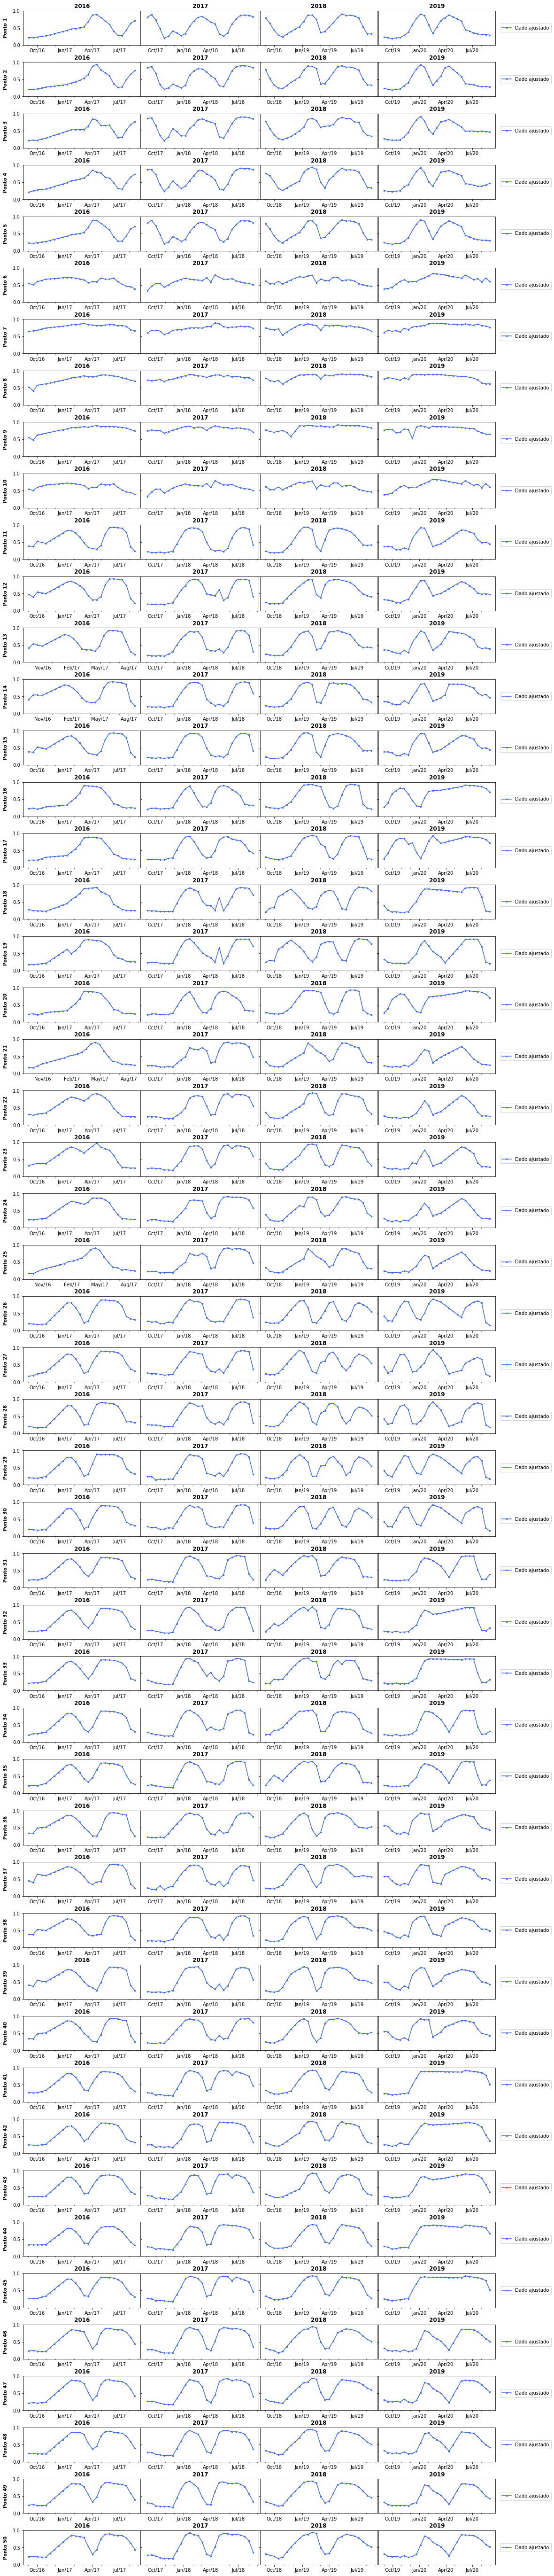

In [76]:
fig, ax = plt.subplots(df_interpolado.shape[1],len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color='royalblue');
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
    ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');


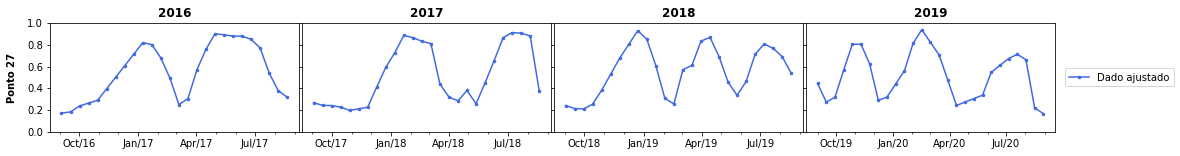

In [5]:
fig, ax = plt.subplots(1,len(anos_ag), figsize=(18,2),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

ponto = 27

for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):

    ax[coluna].set_ylim(0,1)

    months = mdates.MonthLocator(interval=3)
    month_fmt = mdates.DateFormatter('%b/%y')

    months_minor = mdates.MonthLocator()

    ax[coluna].get_xaxis().set_minor_locator(months_minor)
    ax[coluna].get_xaxis().set_major_locator(months)
    ax[coluna].get_xaxis().set_major_formatter(month_fmt)

    ax[coluna].set_title(ano,weight='bold')

    ax[coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color='royalblue');
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

ax[0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
ax[3].legend(bbox_to_anchor=(1.5, .5), loc='center right');

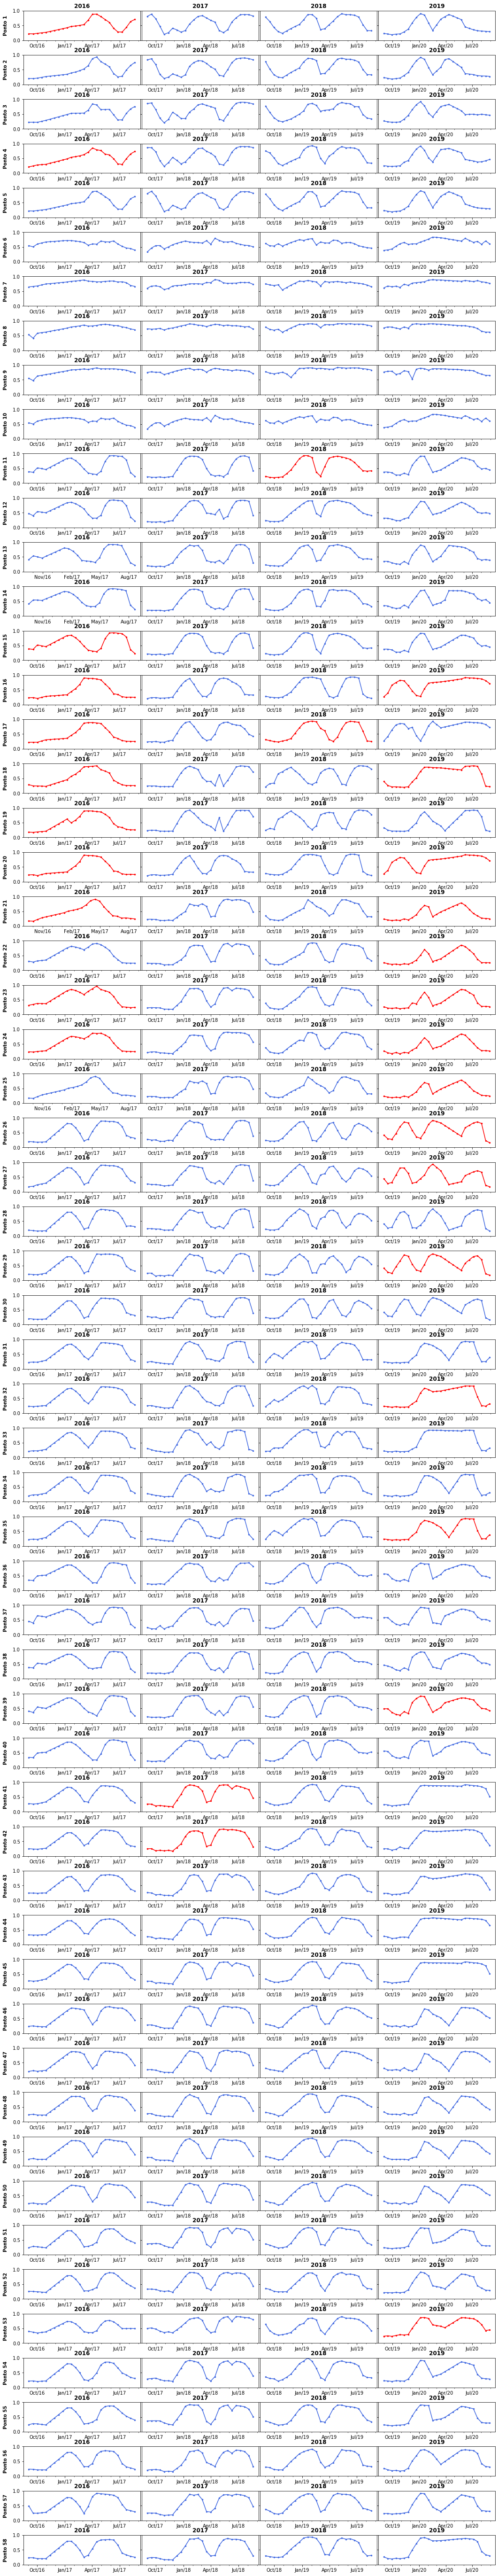

In [100]:
fig, ax = plt.subplots(df_interpolado.shape[1]-11850,len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]-11850):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not classif.loc[ponto, ano]:
            cor = 'red'
        else:
            cor = 'royalblue'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');